<a href="https://colab.research.google.com/github/shatarabelva/PKA/blob/main/Project_PKA_Kelompok_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1 Statistik Data dan Hasil Preprocessing

## 4.1.1 Mengunggah & Mengekstrak Dataset

In [ ]:
from google.colab import files
import zipfile, os

# Upload: pilih train_rev2.zip, valid_rev2.zip, test_rev2.zip
uploaded = files.upload()  # klik dan pilih ketiga zip

def unzip_to_content(zip_name):
    print(f"Unzipping {zip_name} ...")
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall("/content")
    print("Done.")

for name in ["train_rev2.zip", "valid_rev2.zip", "test_rev2.zip"]:
    if name in uploaded:
        unzip_to_content(name)
    else:
        print(f"⚠ {name} belum terupload")

print("Isi /content:", os.listdir("/content"))

Saving test_rev2.zip to test_rev2.zip
Saving train_rev2.zip to train_rev2.zip
Saving valid_rev2.zip to valid_rev2.zip
Unzipping train_rev2.zip ...
Done.
Unzipping valid_rev2.zip ...
Done.
Unzipping test_rev2.zip ...
Done.
Isi /content: ['.config', 'test', 'valid_rev2.zip', 'train_rev2.zip', 'valid', 'train', 'test_rev2.zip', 'sample_data']


## 4.1.2 Menyusun Struktur Dataset (images/labels)

In [ ]:
import glob, shutil, os

base = "/content/datasets/palm_oil"

splits_src = {
    "train": "/content/train",
    "val": "/content/valid",   # 'valid' kita map ke 'val'
    "test": "/content/test"
}

for split, src_dir in splits_src.items():
    img_dir = os.path.join(base, "images", split)
    lbl_dir = os.path.join(base, "labels", split)
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    jpgs = glob.glob(os.path.join(src_dir, "*.jpg"))
    print(f"{split}: ketemu {len(jpgs)} gambar")

    for img_path in jpgs:
        name = os.path.basename(img_path)
        txt_path = img_path.replace(".jpg", ".txt")

        # pindah gambar
        shutil.move(img_path, os.path.join(img_dir, name))

        # pindah label
        if os.path.exists(txt_path):
            shutil.move(txt_path, os.path.join(lbl_dir, os.path.basename(txt_path)))
        else:
            print("⚠ label tidak ditemukan untuk", name)

print("Struktur akhir:")
for root, dirs, files_list in os.walk(base):
    print(root, "->", len(files_list), "files")

train: ketemu 2908 gambar
val: ketemu 835 gambar
test: ketemu 417 gambar
Struktur akhir:
/content/datasets/palm_oil -> 0 files
/content/datasets/palm_oil/labels -> 0 files
/content/datasets/palm_oil/labels/val -> 835 files
/content/datasets/palm_oil/labels/test -> 417 files
/content/datasets/palm_oil/labels/train -> 2908 files
/content/datasets/palm_oil/images -> 0 files
/content/datasets/palm_oil/images/val -> 835 files
/content/datasets/palm_oil/images/test -> 417 files
/content/datasets/palm_oil/images/train -> 2908 files


## 4.1.3 Menyusun File Konfigurasi Dataset (.yaml)

In [ ]:
data_yaml = """
path: /content/datasets/palm_oil

train: images/train
val: images/val
test: images/test

names:
  0: Janjang_kosong
  1: Kurang_masak
  2: TBS_abnormal
  3: TBS_masak
  4: TBS_mentah
  5: Terlalu_masak
"""

with open("/content/palm_oil_yolov5.yaml", "w") as f:
    f.write(data_yaml)

print(open("/content/palm_oil_yolov5.yaml").read())


path: /content/datasets/palm_oil

train: images/train
val: images/val
test: images/test

names:
  0: Janjang_kosong
  1: Kurang_masak
  2: TBS_abnormal
  3: TBS_masak
  4: TBS_mentah
  5: Terlalu_masak



## 4.1.4 Menampilkan Contoh Gambar + Bounding Box

Image: /content/datasets/palm_oil/images/train/frame9kombinasi--135-_png.rf.1ba9fd62853d3bef3f624e3696cac775.jpg
Label: /content/datasets/palm_oil/labels/train/frame9kombinasi--135-_png.rf.1ba9fd62853d3bef3f624e3696cac775.txt


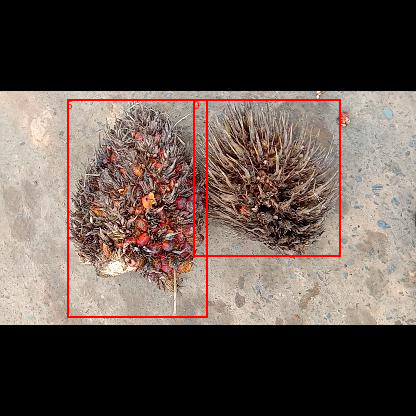

In [ ]:
from PIL import Image, ImageDraw
import glob, os

sample_img = glob.glob("/content/datasets/palm_oil/images/train/*.jpg")[0]
sample_lbl = sample_img.replace("/images/", "/labels/").replace(".jpg", ".txt")

print("Image:", sample_img)
print("Label:", sample_lbl)

img = Image.open(sample_img).convert("RGB")
W, H = img.size
draw = ImageDraw.Draw(img)

with open(sample_lbl) as f:
    for line in f:
        cls, xc, yc, bw, bh = map(float, line.strip().split())
        x1 = (xc - bw/2) * W
        y1 = (yc - bh/2) * H
        x2 = (xc + bw/2) * W
        y2 = (yc + bh/2) * H

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1), str(int(cls)), fill="red")

display(img)

## 4.1.5 Statistik Jumlah Gambar & Distribusi Kelas

In [ ]:
import glob, os
from collections import Counter, defaultdict

base = "/content/datasets/palm_oil"
splits = ["train", "val", "test"]

# 1) Statistik jumlah gambar per split
print("=== Jumlah gambar per split ===")
for s in splits:
    imgs = glob.glob(f"{base}/images/{s}/*.jpg")
    print(f"{s}: {len(imgs)} gambar")

# 2) Statistik distribusi kelas (pakai label YOLO)
# mapping id -> nama kelas (sesuai _darknet.labels)
class_names = {
    0: "Janjang_kosong",
    1: "Kurang_masak",
    2: "TBS_abnormal",
    3: "TBS_masak",
    4: "TBS_mentah",
    5: "Terlalu_masak",
}

print("\n=== Distribusi kelas (berdasarkan semua label TRAIN) ===")
class_counts = Counter()

label_files = glob.glob(f"{base}/labels/train/*.txt")
for lf in label_files:
    with open(lf) as f:
        for line in f:
            if not line.strip():
                continue
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

total_boxes = sum(class_counts.values())
for cid, count in sorted(class_counts.items()):
    name = class_names.get(cid, f"class_{cid}")
    pct = 100.0 * count / total_boxes if total_boxes > 0 else 0
    print(f"{cid} - {name:15s}: {count:5d} box (~{pct:5.2f}%)")

print("\nTotal bounding box di TRAIN:", total_boxes)


=== Jumlah gambar per split ===
train: 2908 gambar
val: 835 gambar
test: 417 gambar

=== Distribusi kelas (berdasarkan semua label TRAIN) ===
0 - Janjang_kosong :   566 box (~ 5.58%)
1 - Kurang_masak   :  1781 box (~17.56%)
2 - TBS_abnormal   :  1843 box (~18.18%)
3 - TBS_masak      :  2142 box (~21.12%)
4 - TBS_mentah     :  2005 box (~19.77%)
5 - Terlalu_masak  :  1803 box (~17.78%)

Total bounding box di TRAIN: 10140


# 4.2 Skenario Pengujian / Eksperimen

## 4.2.1 Instalasi YOLOv5 & Dependensi

In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -qr requirements.txt

import torch
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 17752, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 17752 (delta 66), reused 36 (delta 36), pack-reused 17644 (from 4)
Receiving objects: 100% (17752/17752), 17.16 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (12051/12051), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.1 MB/s eta 0:00:00
PyTorch: 2.9.0+cu126
CUDA available: True


## 4.2.2 Konfigurasi Pelatihan Model

In [ ]:
%cd /content/yolov5
!python train.py \
  --img 416 \
  --batch 16 \
  --epochs 50 \
  --data /content/palm_oil_yolov5.yaml \
  --weights yolov5n.pt \
  --name palm_oil_yolov5n \
  --device 0


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      36/49      1.06G    0.01838    0.02234   0.007262         99        416:  50% 91/182 [00:18<00:20,  4.48it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      36/49      1.06G    0.01837    0.02236   0.007248        107        416:  51% 92/182 [00:18<00:22,  3.94it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      36/49      1.06G    0.01838    0.02237   0.007253        107        416:  51% 93/182 [00:18<00:21,  4.08it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp

## 4.2.3 Menentukan Path Model & Cek best.pt

In [ ]:
import os

run_name = "palm_oil_yolov5n"
weights_path = f"/content/yolov5/runs/train/{run_name}/weights/best.pt"

print("best.pt ditemukan? ->", os.path.exists(weights_path))

best.pt ditemukan? -> True


# 4.3 Hasil Evaluasi Eksperimen

In [ ]:
%cd /content/yolov5

run_name = "palm_oil_yolov5n"  # pastikan sama
weights_path = f"runs/train/{run_name}/weights/best.pt"

!python val.py \
  --data /content/palm_oil_yolov5.yaml \
  --weights {weights_path} \
  --img 416 \
  --task test \
  --save-json

/content/yolov5
val: data=/content/palm_oil_yolov5.yaml, weights=['runs/train/palm_oil_yolov5n/weights/best.pt'], batch_size=32, imgsz=416, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 1767283 parameters, 0 gradients, 4.2 GFLOPs
test: Scanning /content/datasets/palm_oil/labels/test... 417 images, 0 backgrounds, 0 corrupt: 100% 417/417 [00:00<00:00, 1789.68it/s]
test: New cache created: /content/datasets/palm_oil/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 14/14 [00:06<00:00,  2.18it/s]
                   all        417       1410      0.973      0.981       0.99      0.854
  

# 4.4 Analisis Hasil

In [ ]:
%cd /content/yolov5

run_name = "palm_oil_yolov5n"
weights_path = f"runs/train/{run_name}/weights/best.pt"

!python detect.py \
  --weights {weights_path} \
  --source /content/datasets/palm_oil/images/test \
  --img 416 \
  --conf 0.25 \
  --project runs/predict_sawit \
  --name exp1 \
  --exist-ok

/content/yolov5
detect: weights=['runs/train/palm_oil_yolov5n/weights/best.pt'], source=/content/datasets/palm_oil/images/test, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict_sawit, name=exp1, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 1767283 parameters, 0 gradients, 4.2 GFLOPs
image 1/417 /content/datasets/palm_oil/images/test/frame1--22-_png.rf.113fa95bde31014c9755c831218aa8e0.jpg: 416x416 4 Janjang_kosongs, 5.1ms
image 2/417 /content/datasets/palm_oil/images/test/frame1--23-_png.rf.ca82d143019a51d296fe9003393d24fd.jpg: 416x416 4 J

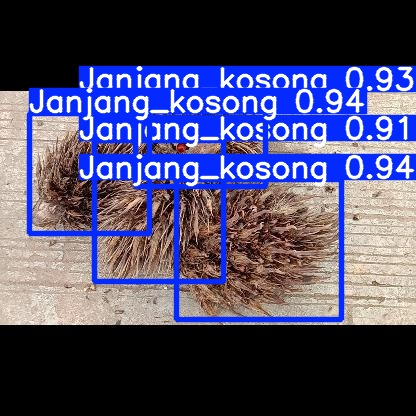

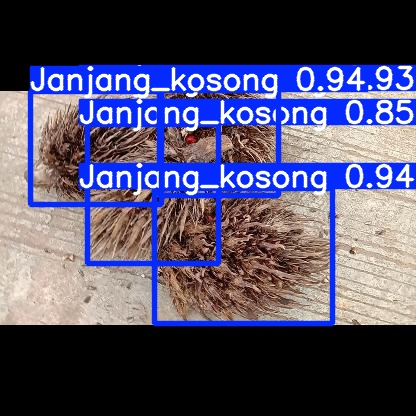

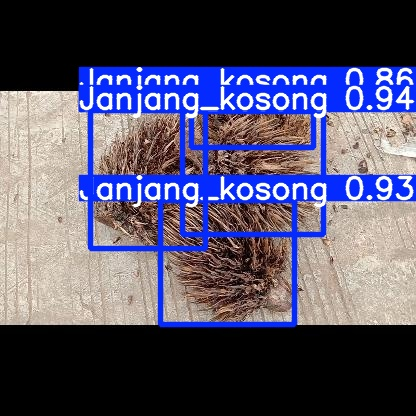

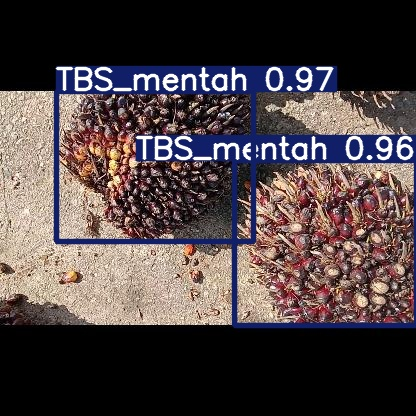

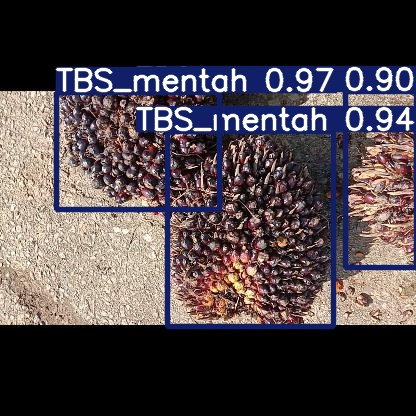

In [ ]:
import glob
from IPython.display import Image, display

pred_dir = "runs/predict_sawit/exp1"
pred_imgs = sorted(glob.glob(pred_dir + "/*.jpg"))[:5]

for p in pred_imgs:
    display(Image(filename=p))

# 4.5 Deployment Model (Export)

In [ ]:
%cd /content/yolov5

run_name = "palm_oil_yolov5n"
weights_path = f"runs/train/{run_name}/weights/best.pt"

!python export.py \
  --weights {weights_path} \
  --include torchscript onnx tflite \
  --img 416 \
  --batch 1

/content/yolov5
export: data=data/coco128.yaml, weights=['runs/train/palm_oil_yolov5n/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx', 'tflite']
YOLOv5 🚀 v7.0-450-g781b9d57 Python-3.12.12 torch-2.9.0+cu126 CPU

Fusing layers... 
Model summary: 157 layers, 1767283 parameters, 0 gradients, 4.2 GFLOPs

PyTorch: starting from runs/train/palm_oil_yolov5n/weights/best.pt with output shape (1, 10647, 11) (3.6 MB)

TorchScript: starting export with torch 2.9.0+cu126...
TorchScript: export success ✅ 1.8s, saved as runs/train/palm_oil_yolov5n/weights/best.torchscript (7.1 MB)

ONNX: starting export with onnx 1.20.0...
W1202 06:35:57.929000 25529 torch/onnx/_internal/exporter/_compat.p

In [ ]:
import os

export_dir = os.path.dirname(weights_path)
files = [
    "best.pt",
    "best.torchscript",
    "best.onnx",
    "best.tflite",
]

print("=== Ukuran model ===")
for fname in files:
    fpath = os.path.join(export_dir, fname)
    if os.path.exists(fpath):
        size_mb = os.path.getsize(fpath) / (1024*1024)
        print(f"{fname:15s}: {size_mb:6.2f} MB")
    else:
        print(fname, "tidak ditemukan")

=== Ukuran model ===
best.pt        :   3.62 MB
best.torchscript:   7.09 MB
best.onnx      :   7.22 MB
best.tflite tidak ditemukan
